# Setup

Make sure you have a fairly recent Python version (I am on Python 3.9.12). Run the following:

```
https://github.com/rycolab/entropy-estimation.git
pip install -e .
```

This will install the entropy package with the necessary dependencies.

In [1]:
import entropy

## Basic usage

Say you have a sample which is a list of observations (for example, `heads` and `tails` from flipping a coin). `entropy.prob()` extracts various useful statistics from your sample, which are to be fed to an entropy estimator.

In [5]:
coins = ['heads', 'heads', 'tails', 'tails']
entropy.prob(coins)

([0.5, 0.5], 4, Counter({'heads': 2, 'tails': 2}))

As you can see, `entropy.prob` returns the discrete probability distribution, the number of observations in the sample, and a counter over the sample.

We can run all the estimators in `entropy.funcs` on our sample to see what's available. By default, `entropy` returns estimates in nats. For reference, 1 nat = $\frac{1}{\ln{2}} \approx 1.44$ bits.

In [6]:
for estimator in entropy.funcs:
    print(estimator.__name__, estimator(*entropy.prob(coins)))

mle 0.6931471805599453
miller_madow 0.8181471805599453
jackknife 0.8630462173553428
horvitz_thompson 0.7393569925972749
chao_shen 0.7393569925972749
wolpert_wolf 0.6166666666666667
nsb 1.4118281434807918


# Experiment 1: A Fair Coin

A fair coin, assigning probablility 0.5 to each heads and tails, would have an entropy of 1 bit $\approx$ 0.6944 nats. How do various estimators converge to the true entropy as we obtain more samples from a fair coin? Here we will simulate 100 coin flips and plot the entropy estimate after each one.

Here is our sample generator:

In [7]:
import random

def coin_flip():
    if random.random() >= 0.5: return 'heads'
    else: return 'tails'

Now we generate the estimates.

In [12]:
X = list(range(100))
estimates = {estimator.__name__: [] for estimator in entropy.funcs}

sample = []
for i in X:
    sample.append(coin_flip())
    stats = entropy.prob(sample) # get necessary statistics
    for estimator in entropy.funcs:
        estimates[estimator.__name__].append(estimator(*stats)) # append estimate

print('First 5 observations:', sample[:5])
print('First 5 MLE entropy estimates:', estimates['mle'][:5])

First 5 observations: ['heads', 'tails', 'tails', 'heads', 'heads']
First 5 MLE entropy estimates: [-0.0, 0.6931471805599453, 0.6365141682948128, 0.6931471805599453, 0.6730116670092565]


Finally, we can plot.

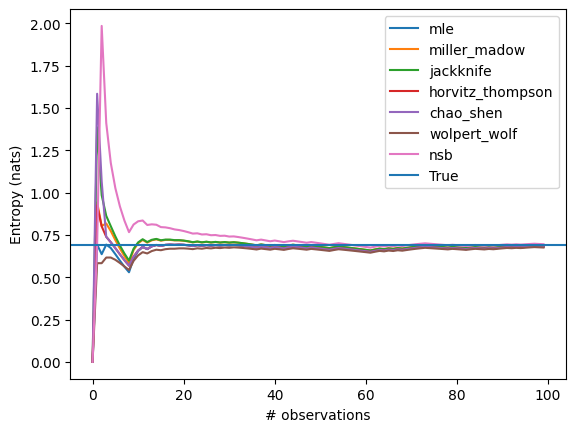

In [17]:
import matplotlib.pyplot as plt
import math

true = math.log(2)
for name, vals in estimates.items():
    plt.plot(X, vals, label=name)

plt.axhline(true, label='True')
plt.legend()
plt.xlabel('# observations')
plt.ylabel('Entropy (nats)')
plt.show()

While we can sort of eyeball the convergence of each estimators, it would be better to use some statistical metrics to compare their performance. From statistical estimation theory, we know to use the mean squared error (MSE) as a good judge of the bias-variance tradeoff. Let's plot that:

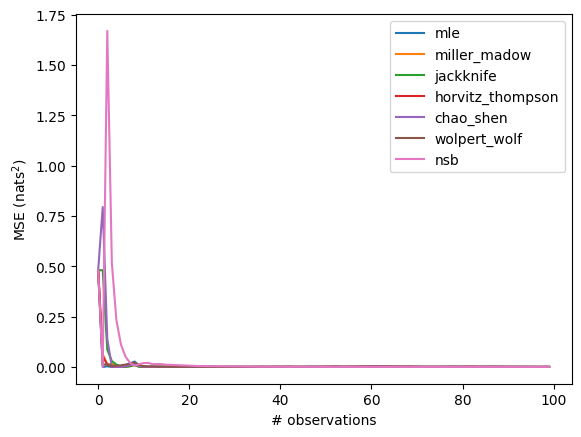

In [21]:
MSEs = {estimator.__name__: [] for estimator in entropy.funcs}
for name in estimates:
    for estimate in estimates[name]:
        MSE = (estimate - true)**2
        MSEs[name].append(MSE)

for name, vals in MSEs.items():
    plt.plot(X, vals, label=name)

plt.legend()
plt.xlabel('# observations')
plt.ylabel('MSE (nats$^2$)')
plt.show()